<img src="./resources/images/banner2.png" width="100%" alt="Encabezado MLDS">

# **Entendimiento y Preparaci√≥n del Corpus**
---
## **0. Integrantes del equipo de trabajo**
---

<table><thead>
  <tr>
    <th>#</th>
    <th>Integrante</th>
    <th>Documento de identidad</th>
  </tr></thead>
<tbody>
  <tr>
    <td>1</td>
    <td>Ivonne Cristina Ruiz P√°ez</td>
    <td>1014302058</td>  
  </tr>
  <tr>
    <td>2</td>
    <td>Diego Alejandro Feliciano Ramos</td>
    <td>1024586904</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Cristhian Enrique C√≥rdoba Trillos</td>
    <td>1030649666</td>
  </tr>
</tbody>
</table>

## **1. An√°lisis Exploratorio de los Textos**
---

### **1.1. Resumen General de los Textos**

________________

- ¬øCu√°l es la fuente origen de los datos?
  * Recopilaci√≥n de publicaciones redes sociales (X, reddit, algunos chatbots). Estas publicaciones fueron recolectadas espec√≠ficamente para realizar un an√°lisis de sentimientos relacionado con la salud mental.

- ¬øCu√°ntos documentos tiene el corpus?
  * El corpus tiene 53.043 docuemntos. En nuestro dataset cada documento corresponde a un mensaje o "tweet" publicado. As√≠, cada registro es un tweet, donde la estructura del dataset inicial tiene con 2 columnas: la primera contiene el mensaje, y la segunda una etiqueta dentro de las siguientes categor√≠as: 1) Ansiedad, 2) Bipolaridad, 3) Depresi√≥n, 4) Normal, 5) Desorden de personalidad, 6) Estr√©s, y 7) Tendencia suicida.

- ¬øEn qu√© idioma se encuentran?
  * Los documentos del corpus son una recopilaci√≥n de posts en distintas redes sociales en idioma ingl√©s.

- ¬øQu√© tama√±o en MB tiene el corpus?
  *  El corpus tiene un peso aproximado de 31.5 MB

- ¬øHay alguna relaci√≥n entre distintos documentos del corpus?
  * Los documentos del corpus est√°n relacionados en sentido de que todos son publicaciones individuales o conversaciones de los usuarios de las redes sociales. Estas publicaciones fueron recopiladas para el an√°lisis de sentimientos, por tanto, no existe una relaci√≥n expl√≠cita entre los docuemntos m√°s all√° de este contexto com√∫n.


### **1.2. Resumen de la Calidad de los Textos**
______________

- ¬øHay datos faltantes o documentos vac√≠os?
  * Hay 0 valores faltantes en la columna "status" mientras hay 362 valores faltantes en al columna "statement". Los 362 valores faltantes en la columna "statement" corresponden al 0.63% del total de registros, as√≠, la proporci√≥n de nulos es muy baja. En conclusi√≥n, la completitud del dataset es del 99.3 %, apr√≥ximadamente.

- ¬øExisten documentos ilegibles o con problemas de codificaci√≥n?
  * Posterior a eliminar valores duplicados, valores nulos y columnas con √∫nicamente valores n√∫mericos, no se evidencian problemas de ilegibilidad o codificaci√≥n.

- ¬øHay mezcla de idiomas en el corpus?, ¬øqu√© se puede hacer al respecto?
  * El corpus est√° construido principalmente en idioma ingl√©s, por tanto, hay una mezcla de idiomas en el mismo, esta mezcla incluye portugu√©s, neerland√©s y algunas entradas ilegibles.

In [58]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Descargar √∫ltima versi√≥n
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-for-mental-health


In [ ]:
##Cargamos nuestra base de datos
path = '/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv'
df_bruto = pd.read_csv(path)

In [ ]:
df_bruto=df_bruto.iloc[:,1:]
pd.concat([df_bruto.head(4), df_bruto.tail(4)])

statement   status
0                                             oh my gosh  Anxiety
1      trouble sleeping, confused mind, restless hear...  Anxiety
2      All wrong, back off dear, forward doubt. Stay ...  Anxiety
3      I've shifted my focus to something else but I'...  Anxiety
53039  selfishness  "I don't feel very good, it's lik...  Anxiety
53040  Is there any way to sleep better? I can't slee...  Anxiety
53041  Public speaking tips? Hi, all. I have to give ...  Anxiety
53042  I have really bad door anxiety! It's not about...  Anxiety

In [27]:
df_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


La siguiente funci√≥n devuelve un peque√±o DataFrame con: nulos y duplicados (conteo‚ÄØ+‚ÄØ%), filas de statement solo num√©ricas y la completitud global del dataset.

In [49]:
def resumen(dataset):
    nulls = dataset.isnull().sum()
    nulls_per = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_per = (dataset.duplicated().sum()) / len(dataset)
    solo_numeros = dataset[dataset['statement'].str.match(r'^\d+(\s\d+)*$', na=False)]
    total_records = len(dataset)
    total_nulls = df_bruto.isnull().sum().sum()
    completitud = (total_records * len(df_bruto.columns) - total_nulls) / (total_records * len(df_bruto.columns))
    info_frame = pd.DataFrame({'Valores_Nulos' : nulls ,
                              'Valores_Nulos %' :nulls_per,
                              'Valores_Duplicados' :duplicated_values,
                              'Valores_Duplicados %':duplicated_values_per,
                              'Filas_Solo_Numeros:': len(solo_numeros),
                               'Completitud_Dataset': completitud})
    return info_frame.T

In [52]:
resumen(df_bruto)

statement       status
Valores_Nulos          362.000000     0.000000
Valores_Nulos %          0.006825     0.000000
Valores_Duplicados    1944.000000  1944.000000
Valores_Duplicados %     0.036650     0.036650
Filas_Solo_Numeros:      1.000000     1.000000
Completitud_Dataset      0.996588     0.996588

In [104]:
# Eliminar datos duplicados en el dataset
df_preclean = df_bruto.drop_duplicates()
# Eliminar valores nulos
df_preclean = df_preclean.dropna()
# Eliminar filas con n√∫meros en el dataset
df_preclean = df_preclean[~df_preclean['statement'].str.contains(r'\d', na=False)]

In [55]:
resumen(df_preclean)

statement    status
Valores_Nulos          0.000000  0.000000
Valores_Nulos %        0.000000  0.000000
Valores_Duplicados     0.000000  0.000000
Valores_Duplicados %   0.000000  0.000000
Filas_Solo_Numeros:    0.000000  0.000000
Completitud_Dataset    0.994805  0.994805

In [56]:
def check_encoding_issues(df, column):
    encoding_issues = []
    for index, value in df[column].items():
        try:
            value.encode('utf-8')
        except UnicodeEncodeError:
            encoding_issues.append(index)
    return encoding_issues

# Verificamos problemas de codificaci√≥n en las columnas 'statement' y 'status'
encoding_issues_statement = check_encoding_issues(df_preclean, 'statement')
encoding_issues_status = check_encoding_issues(df_preclean, 'status')
print()
print(f"Documentos ilegibles o con problemas de codificaci√≥n en la columna 'statement': {encoding_issues_statement}")
print(f"Documentos ilegibles o con problemas de codificaci√≥n en la columna 'status': {encoding_issues_status}")

Documentos ilegibles o con problemas de codificaci√≥n en la columna 'statement': []
Documentos ilegibles o con problemas de codificaci√≥n en la columna 'status': []


### **1.3. Tipos de variables**
---

- ¬øEl corpus tiene una variable objetivo a estimar?, de ser as√≠, ¬øes una variable contin√∫a o categ√≥rica?
- Analice la distribuci√≥n de las etiquetas, identifique si hay desbalanceo de datos.
- Analice los documentos, y determine cu√°l es la distribuci√≥n de la longitud de los documentos a nivel car√°cter o palabra.
- ¬øEl conjunto de datos cuenta con otras variables adicionales?, de ser as√≠, debe analizar cu√°les se incorporar√°n en el modelo y hacer un an√°lisis descriptivo de las mismas.

____________

- ¬øEl corpus tiene una variable objetivo a estimar?, de ser as√≠, ¬øes una variable contin√∫a o categ√≥rica?

  * S√≠, el corpus tiene una variable objetivo a estimar, que es la columna 'status'. Esta variable es de tipo categ√≥rico, la cual contiene alguno de los siguientes categor√≠as respecto de la salud mental: 1) Ansiedad, 2) Bipolaridad, 3) Depresi√≥n, 4) Normal, 5) Desorden de personalidad, 6) Estr√©s, y 7) Tendencia suicida.

- Analice la distribuci√≥n de las etiquetas, identifique si hay desbalanceo de datos.

  * Considerando que una categor√≠a del dataset presenta desbalanceo si tienen una proporci√≥n lo sufiientemente peque√±a respecto de las dem√°s en el dataset. En este caso, si consideramos que una categor√≠a tiene menos del 10% del total la consideramos como una categor√≠a desbalanceada.
      
    As√≠, identificamos desbalanceo en la distribuci√≥n de los datos. En este caso, las categor√≠as con desbalanceo notable son: Ansiedad, Estr√©s, Bipolaridad, y Desorden de personalidad.

    Las cuatro categor√≠as mencionadas tienen una proporci√≥n de 5.8%, 8.7%, 2.9%, y 1.45%, respectivamente.

- Analice los documentos, y determine cu√°l es la distribuci√≥n de la longitud de los documentos a nivel car√°cter o palabra.

  * Distribuci√≥n de la Longitud de los Documentos a Nivel Car√°cter:
    
    La mayor√≠a de los documentos tienen una longitud que var√≠a entre 50 y 150 caracteres. Esto indica que los documentos suelen ser relativamente cortos, lo cual es t√≠pico en publicaciones de redes sociales como tweets.

  * Distribuci√≥n de la Longitud de los Documentos a Nivel Palabra:

    La mayor√≠a de los documentos tienen una longitud que var√≠a entre 10 y 30 palabras. Esto sugiere que los documentos contienen mensajes concisos, lo cual es consistente con el formato de publicaciones en redes sociales.

  * Conclusi√≥n: La longitud de los documentos en el dataset est√° distribuida de manera que la mayor√≠a de los documentos tienen entre 50 y 150 caracteres y entre 10 y 30 palabras. Esta conclusi√≥n es consecuente dado que los tweets est√°n limitados a 280 car√°cteres.

    Este an√°lisis proporciona una visi√≥n clara de la longitud t√≠pica de los documentos en el dataset, lo cual es crucial para dise√±ar estrategias de preprocesamiento y modelado adecuadas.

- ¬øEl conjunto de datos cuenta con otras variables adicionales?, de ser as√≠, debe analizar cu√°les se incorporar√°n en el modelo y hacer un an√°lisis descriptivo de las mismas.

  * No, el dataset no cuenta con variables adicionales.


In [76]:
def distribucion(df):
    # Contar los casos para cada status
    status_counts = df['status'].value_counts()

    # Calcular la proporci√≥n sobre el total
    total_count = len(df)
    status_proportion = (status_counts / total_count) * 100

    # Crear un DataFrame con los resultados
    distribution_df = pd.DataFrame({
        'status': status_counts.index,
        'Conteo': status_counts.values,
        'Proporci√≥n': status_proportion.values
    })
    return distribution_df

In [77]:
distribucion(df_preclean)

status  Conteo  Proporci√≥n
0                Normal   13968   40.089547
1            Depression    9344   26.818208
2              Suicidal    6679   19.169393
3               Anxiety    1930    5.539292
4                Stress    1341    3.848803
5               Bipolar    1062    3.048045
6  Personality disorder     518    1.486711

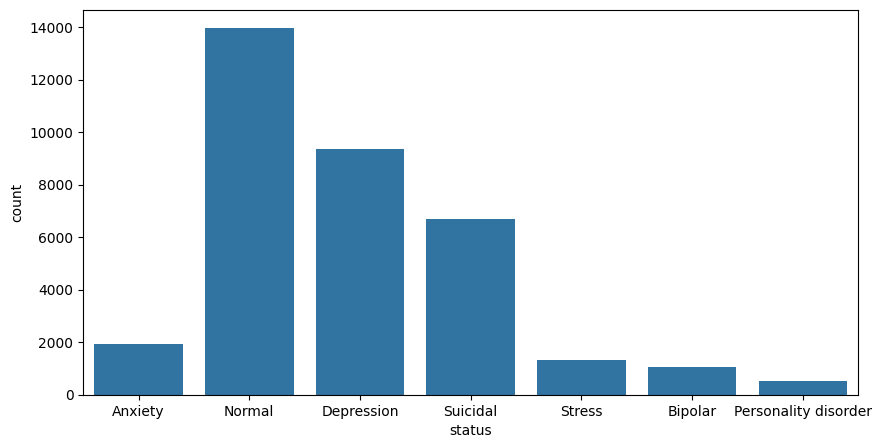

In [66]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_preclean,x='status')
plt.show()

In [105]:
df_preclean['char_length'] = df_preclean['statement'].apply(len)
df_preclean['word_length'] = df_preclean['statement'].apply(lambda x: len(x.split()))
# Distribuciones.
print("Distribuci√≥n de la longitud de los documentos a nivel car√°cter:")
print("/---------------------------------------/")
print(df_preclean['char_length'].describe())
print("/---------------------------------------/")
print("Distribuci√≥n de la longitud de los documentos a nivel palabra:")
print("/---------------------------------------/")
print(df_preclean['word_length'].describe())

Distribuci√≥n de la longitud de los documentos a nivel car√°cter:
/---------------------------------------/
count    34842.000000
mean       345.402015
std        515.991809
min          2.000000
25%         53.000000
50%        164.000000
75%        461.000000
max      32759.000000
Name: char_length, dtype: float64
/---------------------------------------/
Distribuci√≥n de la longitud de los documentos a nivel palabra:
/---------------------------------------/
count    34842.000000
mean        67.970495
std         98.042080
min          1.000000
25%         10.000000
50%         32.000000
75%         91.000000
max       6300.000000
Name: word_length, dtype: float64


<Figure size 1000x500 with 0 Axes>

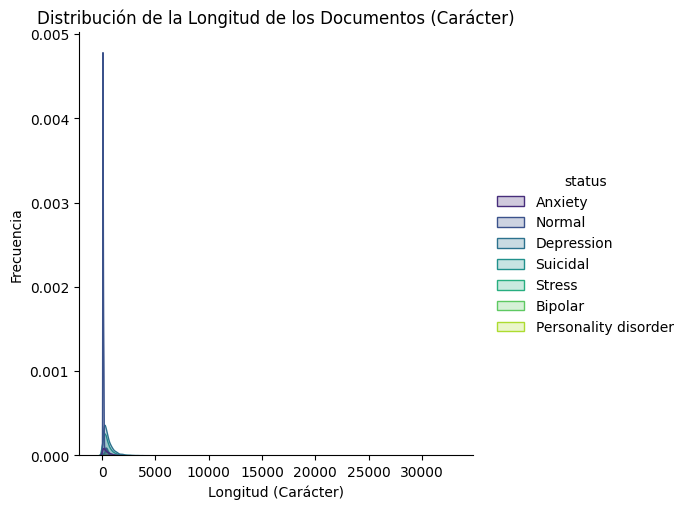

In [106]:
# Distribuci√≥n a nivel car√°cter
plt.figure(figsize=(10, 5))
sns.displot(data=df_preclean, x='char_length', hue='status', kind='kde', fill=True, palette='viridis')
plt.title('Distribuci√≥n de la Longitud de los Documentos (Car√°cter)')
plt.xlabel('Longitud (Car√°cter)')
plt.ylabel('Frecuencia')
plt.show()

<Figure size 1000x500 with 0 Axes>

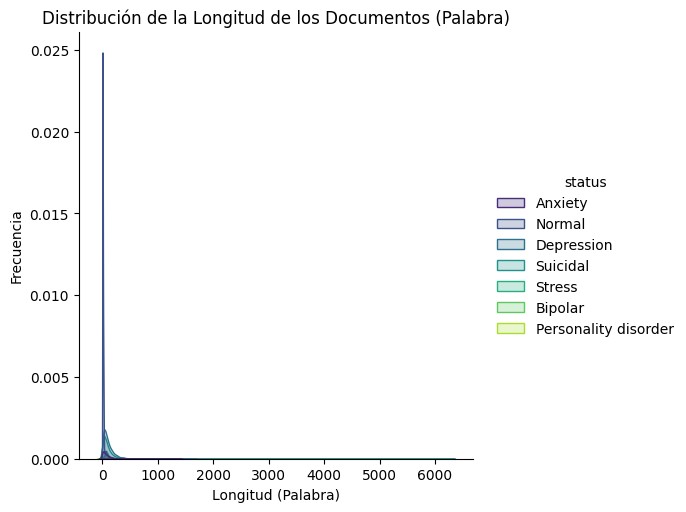

In [107]:
# Distribuci√≥n a nivel palabra
plt.figure(figsize=(10, 5))
sns.displot(data=df_preclean, x='word_length', hue='status', kind='kde', fill=True, palette='viridis')
plt.title('Distribuci√≥n de la Longitud de los Documentos (Palabra)')
plt.xlabel('Longitud (Palabra)')
plt.ylabel('Frecuencia')
plt.show()

### **1.4. Relaci√≥n Entre Variables**
---

- Analice si existe alguna relaci√≥n entre las variables. Puede utilizar medidas de correlaci√≥n o visualizaciones.
- Identifique si hay redundancia entre las variables para una posterior eliminaci√≥n o selecci√≥n.

________

- Analice si existe alguna relaci√≥n entre las variables. Puede utilizar medidas de correlaci√≥n o visualizaciones.

  * char_length y word_length:
  
    La corrrelaci√≥n entre char_length (longitud letras) y word_lenght (longitud palabras) es muy alta (0.96), lo cual es l√≥gico pues ambas variables son construidas a partir de la misma variable base ('statement'). Adicionalmente, la relaci√≥n entre ambas variables es casi lineal, como lo muestra la gr√°fica de scatterplot realizada.

  * 'status' y las longitudes de letras o palabras ('status' y 'word/char_length'):

    *  **Correlaci√≥n Baja entre char_length o word_length respecto de status**: La matriz de correlaci√≥n muestra una baja correlaci√≥n entre la longitud de los documentos (char_length y word_length) y todos los estados de status. Los coeficientes de correlaci√≥n van desde 0.036 hasta 0.091, lo que sugiere que no hay una relaci√≥n fuerte entre la longitud del car√°cter y cualquier estado espec√≠fico.

    * **Relaciones Espec√≠ficas dentro de status**: Algunas relaciones dentro de las variables status muestran mayores niveles de correlaci√≥n, como por ejemplo, entre status_Depression y char/word_length (0.26). Esto indica que estos dos estados tienden a ocurrir juntos m√°s frecuentemente, lo cual puede ser relevante para el an√°lisis de co-ocurrencia de estados emocionales.

    * **Correlaciones Negativas**: Existen algunas relaciones negativas significativas, como entre status_Normal y otros estados como status_Depression (-0.51) o status_Suicidal (-0.29). Esto sugiere que estar en un estado normal est√° inversamente relacionado con estar en un estado depresivo o suicida, lo cual es consistente con la naturaleza opuesta de estos estados emocionales.

    * **Impacto del Estado Emocional en la Longitud del Texto**: La falta de correlaci√≥n significativa entre word_length y las variables dummy de status indica que los diferentes estados emocionales no afectan la cantidad de palabras utilizadas en los documentos. Esto implica que la longitud del texto es independiente del estado emocional.

  
- Identifique si hay redundancia entre las variables para una posterior eliminaci√≥n o selecci√≥n.

  * Existe redundancia entra las variables 'char_length' y 'word_length', pero esto es l√≥gico pues ambas variables son construidas a partir de la misma variable base ('statement').

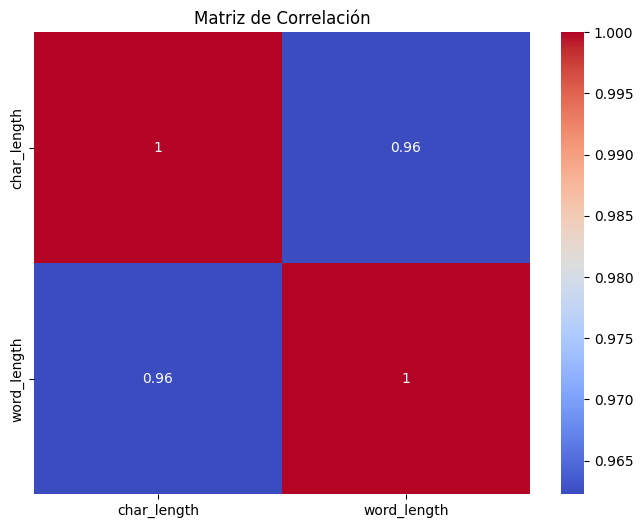

In [98]:
# matriz
correlation_matrix = df_preclean[['char_length', 'word_length']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaci√≥n')
plt.show()

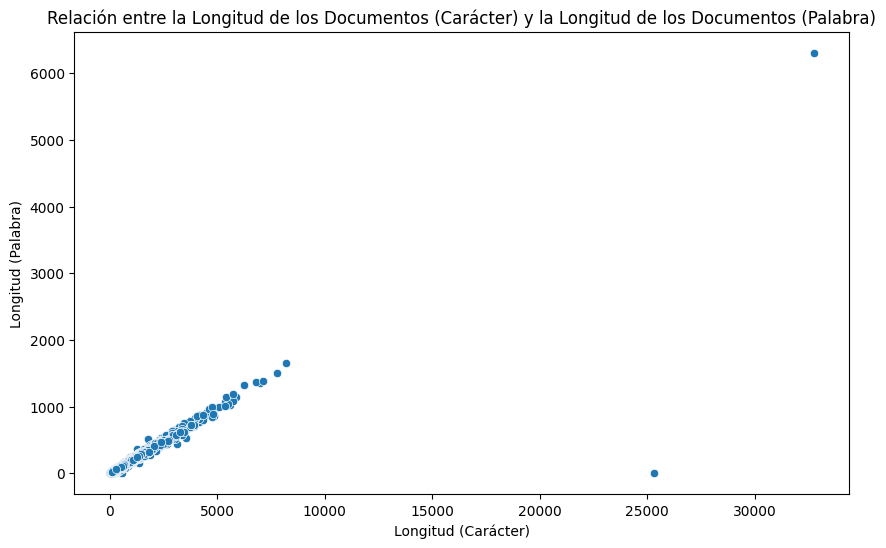

In [97]:
#ScatterPlot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='char_length', y='word_length', data=df_preclean)
plt.title('Relaci√≥n entre la Longitud de los Documentos (Car√°cter) y la Longitud de los Documentos (Palabra)')
plt.xlabel('Longitud (Car√°cter)')
plt.ylabel('Longitud (Palabra)')
plt.show()

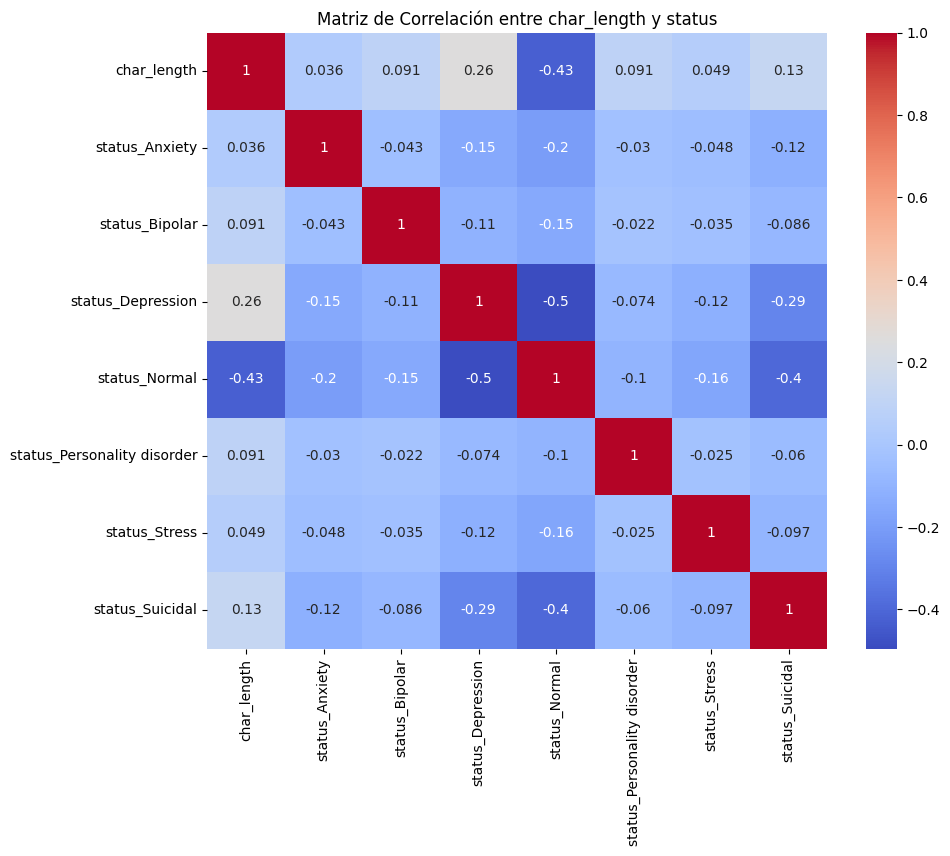

In [116]:
df_dummies = pd.get_dummies(df_preclean['status'], prefix='status')
# Concatenar las variables dummy con el DataFrame original
df_with_dummies_c = pd.concat([df_preclean[['char_length']], df_dummies], axis=1)
correlation_matrix = df_with_dummies_c.corr()
# matriz letras
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaci√≥n entre char_length y status')
plt.show()

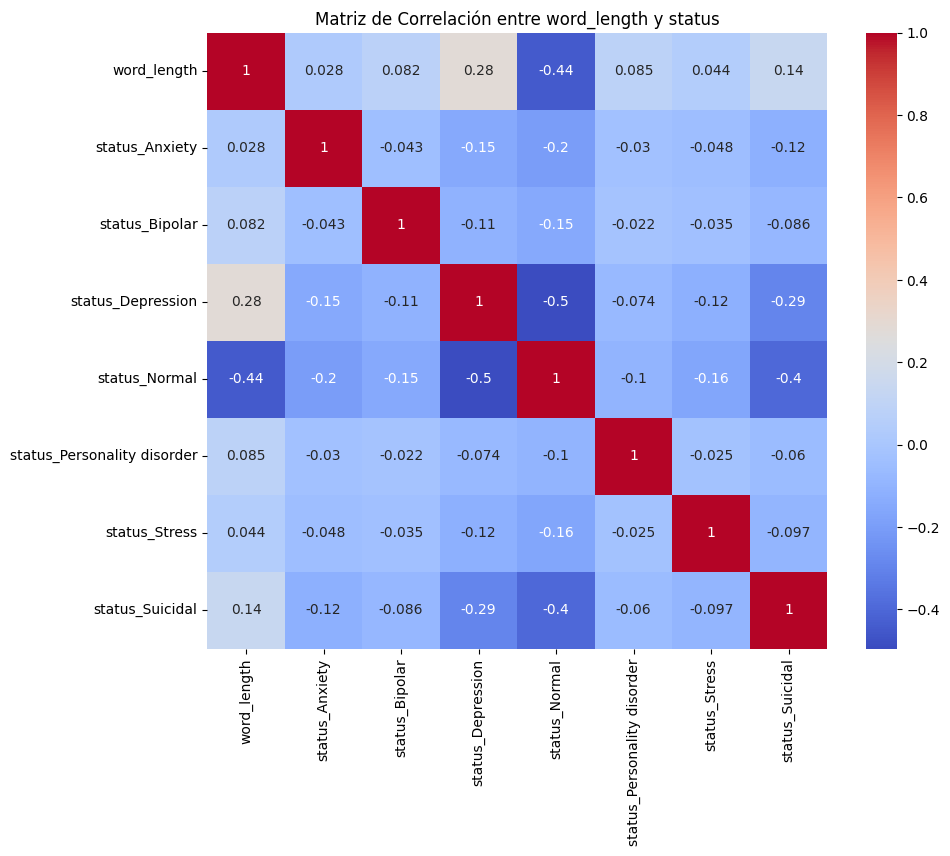

In [117]:
df_with_dummies_w = pd.concat([df_preclean[['word_length']], df_dummies], axis=1)
correlation_matrix = df_with_dummies_w.corr()
# matriz palabras
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlaci√≥n entre word_length y status')
plt.show()

## **2. Limpieza de los Textos**
---

La selecci√≥n de las t√©cnicas de preprocesamiento del corpus puede variar en cada conjunto de datos. Recuerde que puede aplicar (no necesariamente todas) las t√©cnicas generales vistas en el curso, tales como:

- Tokenizacion
- Normalizaci√≥n de textos.
- Limpieza con expresiones regulares.
- Lematizaci√≥n.
- Filtrado de palabras.
- Modificaciones en la graf√≠a.

In [ ]:
%pip install textblob kagglehub emoji

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 590.6/590.6 kB 15.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11.1M/11.1M [00:00<00:00, 19.2MB/s]

Extracting files...


Path to dataset files: /Users/diegof/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [ ]:
# Load the data
path = '/Users/diegof/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv'
df = pd.read_csv(path)

In [ ]:
# Display the first few rows of the dataframe
print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


La siguiente funci√≥n de preprocesamiento est√° dise√±ada para limpiar y normalizar un texto antes de llevar a cabo an√°lisis posteriores (como an√°lisis de sentimientos). 

A continuaci√≥n se detalla lo que hace cada parte del c√≥digo:
1. Conversi√≥n a String: Se asegura que el input sea interpretado como una cadena de texto. Esto evita errores si se recibiera otro tipo de dato.
2.	Normalizaci√≥n (Min√∫sculas): Convierte todo el texto a min√∫sculas para eliminar distinciones entre may√∫sculas y min√∫sculas, lo que facilita la comparaci√≥n y el procesamiento posterior.
3.	Limpieza con Expresiones Regulares (Regex):
	* Eliminaci√≥n de URLs: Se remueven secuencias que correspondan a direcciones web (http, https, www).
	* Eliminaci√≥n de menciones y hashtags: Se eliminan tokens que comienzan con ‚Äò@‚Äô o ‚Äò#‚Äô (t√≠picos en redes sociales).
	* Eliminaci√≥n de caracteres especiales y n√∫meros: Se filtran todos los caracteres que no son letras ni espacios, dejando solo el alfabeto.
4.	Tokenizaci√≥n: Utiliza word_tokenize de NLTK para dividir el texto en una lista de palabras o tokens, lo que permite tratar cada t√©rmino de forma individual.
5.	Filtrado de Stopwords: Se utiliza el conjunto de palabras de poco valor sem√°ntico (stopwords) en ingl√©s de NLTK para filtrar y eliminar palabras comunes (por ejemplo, ‚Äúthe‚Äù, ‚Äúand‚Äù, ‚Äúis‚Äù) que suelen aportar poco al an√°lisis en t√©rminos de contenido informativo.
6.	Conversi√≥n de Emojis a Texto: Con demojize, cada token que contenga un emoji se reemplaza por su representaci√≥n textual (por ejemplo, üòä se convierte en :blush:). Esto permite capturar la informaci√≥n emocional de los emojis en forma de texto.
7.	Lematizaci√≥n: Se emplea WordNetLemmatizer para transformar cada token a su forma base o ra√≠z (por ejemplo, ‚Äúrunning‚Äù se convierte en ‚Äúrun‚Äù). Esto ayuda a reducir la variabilidad morfol√≥gica y mejora la consistencia en el an√°lisis.
8.	Reconstrucci√≥n del Texto Limpio: Finalmente, se vuelven a unir los tokens procesados en una cadena de texto, obteniendo el texto final ‚Äúlimpio‚Äù y normalizado.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize

# Descargar tokenizer y stopwords de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Funci√≥n para limpieza, normalizaci√≥n y tokenizaci√≥n
def limpiar_texto(texto):
    # Convertir a string por seguridad
    texto = str(texto)

    # 1. Normalizaci√≥n
    texto = texto.lower()

    # 2. Limpieza con Regex
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)  # eliminar links
    texto = re.sub(r'@\w+|#\w+', '', texto)                # eliminar menciones y hashtags
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)              # eliminar caracteres especiales y n√∫meros

    # 3. Tokenizaci√≥n b√°sica
    tokens = word_tokenize(texto)

    # 4. Filtrar stopwords (palabras comunes que no aportan informaci√≥n)
    stop_words = set(stopwords.words('english')) 
    tokens_filtrados = [token for token in tokens if token not in stop_words]

    # 5. Reemplazar emojis por su representaci√≥n textual
    tokens_demojizados = [demojize(token) for token in tokens_filtrados]  

    # 6. Lematizaci√≥n (transformar palabras a su ra√≠z)
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens_demojizados]
    
    # 7. Volver a unir tokens
    texto_limpio = ' '.join(tokens_lemmatizados)

    return texto_limpio

# Aplicar limpieza
df['clean_text'] = df['statement'].apply(limpiar_texto)

# Ver resultado
print(df[['statement', 'clean_text']].head())

[nltk_data] Downloading package punkt to /Users/diegof/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                          text_clean  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3  ive shifted focus something else im still worried  
4                im restless restless month boy mean  


Por √∫ltimo se deja un ejemplo de c√≥mo ha quedado un texto procesado con la funci√≥n anterior:

In [ ]:
row = df[df['Unnamed: 0'] == 1]['statement']
clean_row = df[df['Unnamed: 0'] == 1]['clean_text']
print(row.values[0])
print(clean_row.values[0])

trouble sleeping, confused mind, restless heart. All out of tune
trouble sleeping confused mind restless heart tune


## **Cr√©ditos**

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebasti√°n Lara Ram√≠rez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Dise√±o de im√°genes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualizaci√≥n:**
    - [Edder Hern√°ndez Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingenier√≠a*